### This notebook generates the CAPE-ascent rate relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from scipy import stats
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

## Loading ERA-I data

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(695667,)


In [4]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)
print(plev_ERAI)
# Read in the vertical velocities
omega_array = nc_open_compile(file_years,"omega",'stack')[tropical_indx]
# Extract the value around 550 hPa
omega_ERAI_mid = omega_array[:,14]
# Extract the value around 200 hPa
omega_ERAI_hi = omega_array[:,4]

# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_indx]

# Filter for negative values of omega (ascent rates)
omega_ERAI_mid_n, cape_ERAI_n = negative_vals( omega_ERAI_mid, cape_ERAI )
omega_ERAI_hi_n, _ = negative_vals( omega_ERAI_hi, cape_ERAI )

_, capepre6_ERAI_n = negative_vals( omega_ERAI_mid, capepre6_ERAI )
_, rad_ERAI_n = negative_vals( omega_ERAI_mid, rad_ERAI )
_, ctt_ERAI_n = negative_vals( omega_ERAI_mid, ctt_ERAI )
_, minctt_ERAI_n = negative_vals( omega_ERAI_mid, minctt_ERAI )
_, lifetime_ERAI_n = negative_vals( omega_ERAI_mid, lifetime_ERAI )

_, rad_ERAI_n2 = negative_vals( omega_ERAI_hi, rad_ERAI )
_, ctt_ERAI_n2 = negative_vals( omega_ERAI_hi, ctt_ERAI )
_, minctt_ERAI_n2 = negative_vals( omega_ERAI_hi, minctt_ERAI )
_, lifetime_ERAI_n2 = negative_vals( omega_ERAI_hi, lifetime_ERAI )

[ 122.61370087  142.90170288  165.08859253  189.14660645  215.02510071
  242.65229797  272.05929565  303.21740723  336.04391479  370.40719604
  406.1328125   443.00860596  480.79071045  519.20928955  557.97338867
  596.77740479  635.30603027  673.24029541  710.26269531  746.06347656
  780.34552002  812.83032227  843.26342773  871.42028809  897.11181641
  920.18927002  940.55108643  958.14770508  972.98681641  985.13989258
  994.74719238 1002.02362061]


In [5]:
# Filter for positive values of omega (descent rates)
omega_ERAI_mid_p, cape_ERAI_p = positive_vals( omega_ERAI_mid, cape_ERAI )
omega_ERAI_hi_p, _ = positive_vals( omega_ERAI_hi, cape_ERAI )

_, capepre6_ERAI_p = positive_vals( omega_ERAI_mid, capepre6_ERAI )
_, rad_ERAI_p = positive_vals( omega_ERAI_mid, rad_ERAI )
_, ctt_ERAI_p = positive_vals( omega_ERAI_mid, ctt_ERAI )
_, minctt_ERAI_p = positive_vals( omega_ERAI_mid, minctt_ERAI )
_, lifetime_ERAI_p = positive_vals( omega_ERAI_mid, lifetime_ERAI )

_, rad_ERAI_p2 = positive_vals( omega_ERAI_hi, rad_ERAI )
_, ctt_ERAI_p2 = positive_vals( omega_ERAI_hi, ctt_ERAI )
_, minctt_ERAI_p2 = positive_vals( omega_ERAI_hi, minctt_ERAI )
_, lifetime_ERAI_p2 = positive_vals( omega_ERAI_hi, lifetime_ERAI )

In [27]:
nbins = 25
pc2 = 99
maxcape = 3700
cape_bins_ascent, ascent_vals, _, ascent_99_vals, _, ascent_error, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n, omega_ERAI_mid_n, pc2=pc2, threshold=20 ) 
capepre6_bins_ascent, ascent_vals2, _, ascent_99_vals2, cape_error_ascent2, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, capepre6_ERAI_n, omega_ERAI_mid_n, pc2=pc2, threshold=20 ) 

# create bins in CAPE and evaluate corresponding ascent rate percentiles for smallest systems
cape_bins_small, ascent_vals_small, _, ascent_99_vals_small, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[rad_ERAI_n <= 110], omega_ERAI_mid_n[rad_ERAI_n <= 110], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for largest systems
cape_bins_large, ascent_vals_large, _, ascent_99_vals_large, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[rad_ERAI_n > 150], omega_ERAI_mid_n[rad_ERAI_n > 150], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for deepest systems
cape_bins_deep, ascent_vals_deep, _, ascent_99_vals_deep, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[minctt_ERAI_n <= 185], omega_ERAI_mid_n[minctt_ERAI_n <= 185], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for shallowest systems
cape_bins_shallow, ascent_vals_shallow, _, ascent_99_vals_shallow, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[minctt_ERAI_n > 205], omega_ERAI_mid_n[minctt_ERAI_n > 205], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for longest lived systems
cape_bins_old, ascent_vals_old, _, ascent_99_vals_old, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[lifetime_ERAI_n > 12], omega_ERAI_mid_n[lifetime_ERAI_n > 12], pc2=pc2, threshold=20 )

# create bins in CAPE and evaluate corresponding ascent rate percentiles for shorteest lived systems
cape_bins_young, ascent_vals_young, _, ascent_99_vals_young, _, _, _, _ = \
    bin_stat_function( nbins, 0, maxcape, cape_ERAI_n[lifetime_ERAI_n <= 3], omega_ERAI_mid_n[lifetime_ERAI_n <= 3], pc2=pc2, threshold=20 )

### Look at the histogram of ascent and descent rates across different morphologies

0.24913978933722303
0.25888191704281954
0.2340356593629496
0.24913978933722303
0.22225320134921023
0.26068607560398577


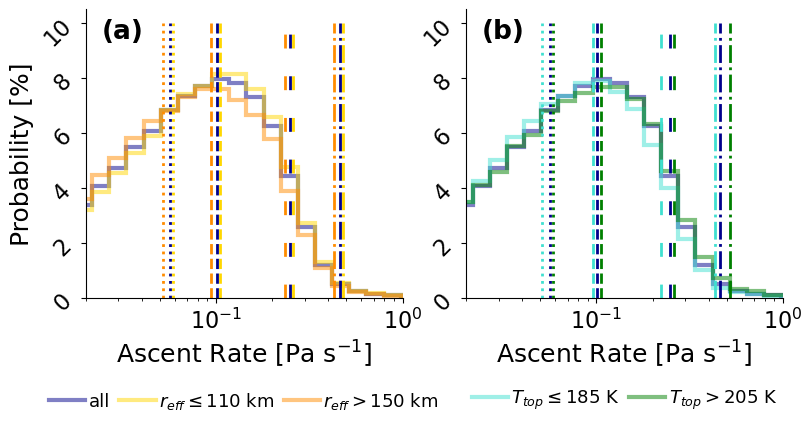

In [28]:
# Only do the two-panel version after all
ascent550_list = [ [omega_ERAI_mid_n, omega_ERAI_mid_n[rad_ERAI_n <= 110], omega_ERAI_mid_n[rad_ERAI_n > 150]],
                   [omega_ERAI_mid_n, omega_ERAI_mid_n[minctt_ERAI_n <= 185], omega_ERAI_mid_n[minctt_ERAI_n > 205]] ]
ascent200_list = [ [omega_ERAI_hi_n, omega_ERAI_hi_n[rad_ERAI_n2 <= 110], omega_ERAI_hi_n[rad_ERAI_n2 > 150]],
                   [omega_ERAI_hi_n, omega_ERAI_hi_n[minctt_ERAI_n2 <= 185], omega_ERAI_hi_n[minctt_ERAI_n2 > 205]] ]

lbls = [ ['all', r'$r_{eff}\leq$110 km', r'$r_{eff}>$150 km'],
         ['', r'$T_{top}\leq$185 K', r'$T_{top}>$205 K'] ]
let = [ '(a)', '(b)' ]

farbe = [ ['darkblue', 'gold', 'darkorange'], ['darkblue', 'turquoise', 'green'] ]
widths = [ 3.5, 2, 2, 3.5, 2, 2 ]
nbin = 50
fs = 18
fig, ax = plt.subplots( 1, 2, figsize=(9,3.75) )
                  
for j, ascent550, ascent200, a in zip( np.arange(len(ascent550_list)), ascent550_list, ascent200_list, ax.flatten() ):
    for k in np.arange(3):
        #print(np.nanmin(ascent550),np.nanmean(ascent550),np.nanmax(ascent550))
        i = np.argwhere( ~np.isnan(ascent550[k]) )
        wgts = np.ones_like( ascent550[k][i[:,0]] ) / float(len( ascent550[k][i[:,0]] ))*100
        h, edges = np.histogram( ascent550[k][i[:,0]], weights=wgts, bins=np.logspace(-3.5, 1, nbin) )
        a.stairs( h, edges, edgecolor=farbe[j][k], lw=3, alpha=0.5, label=lbls[j][k] )
        m = np.nanmean(ascent550[k][i[:,0]])
        a.plot( [m, m], [0, 10], color=farbe[j][k], ls='--', lw=2 )
        m = np.nanpercentile(ascent550[k][i[:,0]], 99)
        a.plot( [m, m], [0, 10], color=farbe[j][k], ls='-.', lw=2 )
    
        i = np.argwhere( ~np.isnan(ascent200[k]) )
        m = np.nanmean(ascent200[k][i[:,0]])
        a.plot( [m, m], [0, 10], color=farbe[j][k], ls=':', lw=2 )
        m = np.nanpercentile(ascent200[k][i[:,0]], 99)
        print(m)
        a.plot( [m, m], [0, 10], color=farbe[j][k], ls=(0,(5,10)), lw=2 )
    
    a.text( 0.05, 0.9, let[j], weight='bold', fontsize=fs+1, transform=a.transAxes )

for a in ax.flatten():
    a.set_xlim( [0.02, 1] )
    a.set_xscale( 'log' )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params( labelsize=fs-2 )
    a.tick_params( axis='y', rotation=45 )
    a.legend( loc='lower center', ncol=3, fontsize=fs-5, handletextpad=0.2, columnspacing=0.5,
             bbox_to_anchor=(0.5, -0.45), frameon=False )
    
ax[1].set_xlabel( r'Ascent Rate [Pa s$^{-1}$]', fontsize=fs )
ax[0].set_xlabel( r'Ascent Rate [Pa s$^{-1}$]', fontsize=fs )
ax[0].set_ylabel( r'Probability [%]', fontsize=fs )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-distribution-ERAI.pdf', bbox_inches='tight' )
plt.show()

### Then look at the scaling of ascent rates against CAPE across different morphologies

In [29]:
def squared(x):
    return x**2

def sqrt(x):
    return np.sqrt(x)

0.002830793506158712 0.8565342989591116 6.980002514008021e-10
0.0020059711351149397 0.8777156516560233 1.202143526718077e-09
0.0031420350308279618 0.906868622321464 3.0366207343885814e-11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.02091105343615651 0.5411149433655505 9.570046041239246e-05
0.009608524507994952 0.3070331942403433 0.013826882480707717
0.02189228987009316 0.4974246804695254 0.00035555241573568554
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.002830793506158712 0.8565342989591116 6.980002514008021e-10
0.0034950108326578014 0.6834588075339576 2.1096069319097286e-06
0.0018021552532623774 0.7979679478336296 5.037907941441146e-08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.02091105343615651 0.5411149433655505 9.570046041239246e-05
0.017491849817271015 0.3983727287682625 0.0021529980125593786
0.004409665196587849 0.21539612886429763 0.039267433901502356
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.002830793506158712 0.8565342989591116 6.980002514008021e-10
0.0018418285688056434 0.7077201415102718 1.2163452134631916e-05
0.00

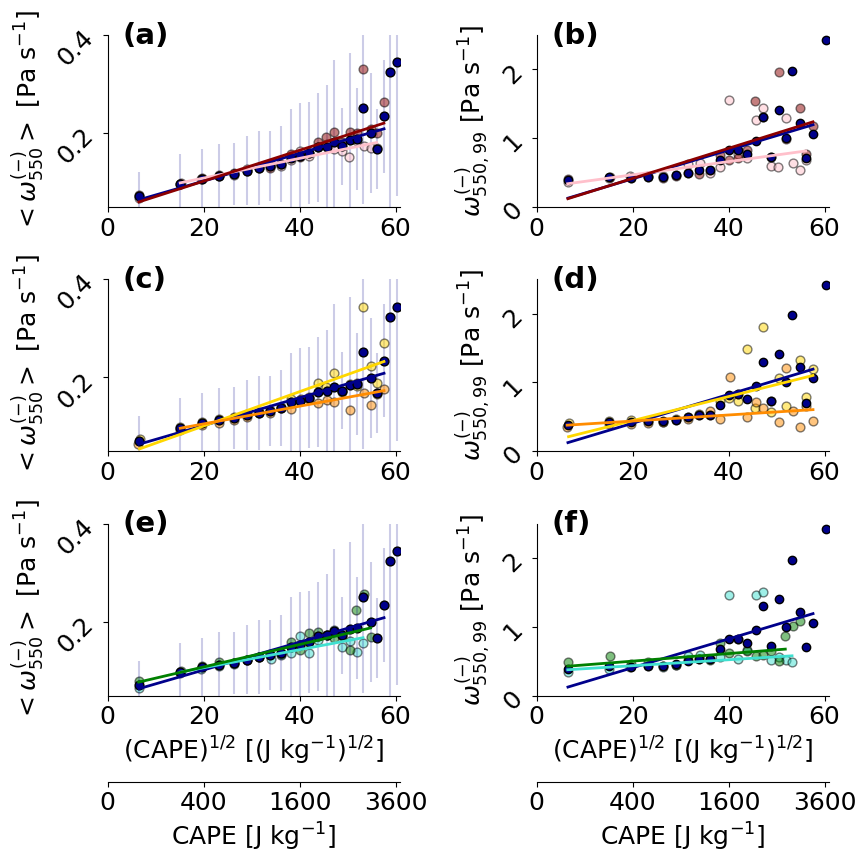

In [33]:
fig, ax = plt.subplots( 3, 2, figsize =(9, 9) )
sz = 40

ylab = [ r'$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', '$\omega_{550, 99}^{(-)}$ [Pa s$^{-1}$]' ] * 3
labels = [ '', '' , '', '' , r'(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]', '(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)', '(e)', '(f)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xticks( [0, np.sqrt(400), np.sqrt(1600), np.sqrt(3600)] )
    axis.set_xlim( [0, np.sqrt(maxcape)] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        axis.scatter( np.sqrt(cape_bins_ascent), ascent_vals, s=sz, color = 'darkblue', edgecolor='black' )
        axis.errorbar( np.sqrt(cape_bins_ascent), ascent_vals, yerr=ascent_error/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.2 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_ascent), ascent_vals )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_old), ascent_vals_old, s=sz, color='pink', edgecolor='black', alpha=0.5, zorder=-1 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_old), ascent_vals_old )
        axis.plot( x_input, y_predicted, color='pink', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_young), ascent_vals_young, s=sz, color='darkred', edgecolor='black', alpha=0.5, zorder=-1 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_young), ascent_vals_young )
        axis.plot( x_input, y_predicted, color='darkred', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        axis.set_ylim([0.05, 0.4])
        
    if i == 1:
        axis.scatter( np.sqrt(cape_bins_ascent), ascent_99_vals, color='darkblue', edgecolor='black' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_ascent), ascent_99_vals )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_old), ascent_99_vals_old, s=sz, color='pink', edgecolor='black', zorder=-5, alpha=0.5 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_old), ascent_99_vals_old )
        axis.plot( x_input, y_predicted, color='pink', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_young), ascent_99_vals_young, s=sz, color='darkred', edgecolor='black', zorder=-5, alpha=0.5)
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_young), ascent_99_vals_young )
        axis.plot( x_input, y_predicted, color='darkred', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        axis.set_ylim([0, 2.5])
        
    if i == 2:
        axis.scatter( np.sqrt(cape_bins_ascent), ascent_vals, s=sz, color = 'darkblue', edgecolor='black' )
        axis.errorbar( np.sqrt(cape_bins_ascent), ascent_vals, yerr=ascent_error/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.2 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_ascent), ascent_vals )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_small), ascent_vals_small, s=sz, color='gold', edgecolor='black', alpha=0.5, zorder=-1 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_small), ascent_vals_small )
        axis.plot( x_input, y_predicted, color='gold', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_large), ascent_vals_large, s=sz, color='darkorange', edgecolor='black', alpha=0.5, zorder=-1 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_large), ascent_vals_large )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        axis.set_ylim([0.05, 0.4])
        
    elif i == 3:
        axis.scatter( np.sqrt(cape_bins_ascent), ascent_99_vals, color='darkblue', edgecolor='black' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_ascent), ascent_99_vals )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_small), ascent_99_vals_small, s=sz, color='gold', edgecolor='black', zorder=-5, alpha=0.5 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_small), ascent_99_vals_small )
        axis.plot( x_input, y_predicted, color='gold', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_large), ascent_99_vals_large, s=sz, color='darkorange', edgecolor='black', zorder=-5, alpha=0.5)
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_large), ascent_99_vals_large )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        axis.set_ylim([0, 2.5])
        
    elif i == 4:
        axis.scatter( np.sqrt(cape_bins_ascent), ascent_vals, s=sz, color = 'darkblue', edgecolor='black' )
        axis.errorbar( np.sqrt(cape_bins_ascent), ascent_vals, yerr=ascent_error/2, 
                      color = 'darkblue', ls='none', zorder=-1, alpha=0.2 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_ascent), ascent_vals )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_deep), ascent_vals_deep, s=sz, color='turquoise', edgecolor='black', alpha=0.5, zorder=-2 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_deep), ascent_vals_deep )
        axis.plot( x_input, y_predicted, color='turquoise', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_shallow), ascent_vals_shallow, s=sz, color='green', edgecolor='black' , alpha=0.5, zorder=-2)
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_shallow), ascent_vals_shallow )
        axis.plot( x_input, y_predicted, color='green', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        ax2 = axis.secondary_xaxis( -0.5, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        axis.set_ylim([0.05, 0.4])
    
    elif i == 5:
        axis.scatter( np.sqrt(cape_bins_ascent), ascent_99_vals, color='darkblue', edgecolor='black' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_ascent), ascent_99_vals )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_deep), ascent_99_vals_deep, s=sz, color='turquoise', edgecolor='black', zorder=-5, alpha=0.5 )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_deep), ascent_99_vals_deep )
        axis.plot( x_input, y_predicted, color='turquoise', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_shallow), ascent_99_vals_shallow, s=sz, color='green', edgecolor='black', zorder=-5, alpha=0.5)
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_shallow), ascent_99_vals_shallow )
        axis.plot( x_input, y_predicted, color='green', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue**2, out.pvalue)
        
        ax2 = axis.secondary_xaxis( -0.5, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        axis.set_ylim([0, 2.5])

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/ascent-CAPE-ERAI-percentiles.pdf', bbox_inches='tight' )
plt.show() 